# To do list

- Probar con CWT
- Crear ICWT
- Filtrar con un pasabajo que permita reconocer el $\textit{heartbeat}$

# To do completed
- Aplicar algoritmo de denoising (función $\texttt{denoising}$\_$\texttt{signal}$)
- Aplicar algoritmo de corte de frecuencias en eliminación de murmur (función $\texttt{murmur}$\_$\texttt{elimination}$)
- Crear función que permita trabajar el DWT por niveles (ingresando la cantidad de niveles a descomponer)
- Aplicar idea de Wavelet Packets
- Aplicar distintos tipos de filtro a downsampling (función $\texttt{lowpass}$\_$\texttt{filter}$)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal
from IPython.display import Audio
import wavio
import pywt
import pycwt
import cvxpy as cp

# Funciones auxiliares

In [2]:
def hamming_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.53836 - 0.46164*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])

In [3]:
def recognize_peaks_by_derivates(x, signal_in, peak_type='min', tol_dx=0.01,
    tol_d2x=1e-2, lookup=1500, plot=False):
    # Se definen las derivadas 
    dx = np.gradient(signal_in, x)
    d2x = np.gradient(dx, x)
    
    # Buscando los puntos donde la derivada se vuelve cero
    der_vect_0 = [i for i in range(len(dx)) if abs(dx[i]) <= tol_dx]
    
    # Y definiendo si estos puntos corresponden a mínimos o máximos se realiza
    if peak_type == 'min':
        sel_indexes = [i for i in der_vect_0 if d2x[i] >= tol_d2x]
    elif peak_type == 'max':
        sel_indexes = [i for i in der_vect_0 if d2x[i] <= - tol_d2x]
    elif peak_type == 'all':
        sel_indexes = der_vect_0
    else:
        raise ValueError('La opcion de eleccion de peak utilizada no es valida.')
    
    # Seleccionando un punto característico de la región (ya que
    # muchos de los "puntos" aparecen agrupados en más puntos). En primer lugar,
    # se obtiene un vector de diferencias para conocer los puntos en los que se
    # pasa de un cluster a otro
    dif_indexes = [i + 1 for i in range(len(sel_indexes) - 1)
                   if sel_indexes[i + 1] - sel_indexes[i] > 1] + \
                  [len(sel_indexes) + 1]

    # Separando los clusters de puntos y encontrando el índice representativo de
    # cada uno
    begin = 0
    out_indexes = []
    for i in dif_indexes:
        # Definición del punto posible. Se hace round en caso de que sea un
        # decimal, e int para pasarlo si o si a un elemento tipo "int" para
        # indexar 
        possible_point = int(round(np.mean(sel_indexes[begin:i])))
        
        # Finalmente, se debe reconocer si este punto es realmente un mínimo o
        # un  máximo y no un punto de inflexión. Para ello se revisará en un
        # rango de 'lookup' alrededor de este punto. Definiendo los puntos a
        # revisar 
        look_before = signal_in[possible_point - lookup] \
            if possible_point - lookup >= 0 else signal_in[0]
        look_after  = signal_in[possible_point + lookup] \
            if possible_point + lookup <= len(signal_in) else signal_in[len(signal_in)-1]

        # Luego, realizando la comparación
        if peak_type == 'min':
            # Corroborando que alrededor de este punto se forma un "valle"
            if (look_after > signal_in[possible_point] and 
                look_before > signal_in[possible_point]):
                out_indexes.append(possible_point)

        elif peak_type == 'max':
            # Corroborando que alrededor de este punto se forma una "cueva"
            if (look_after < signal_in[possible_point] and 
                look_before < signal_in[possible_point]):
                out_indexes.append(possible_point)
        
        elif peak_type == 'all':
            # Corroborando alguno de los 2 casos anteriores
            if (look_after > signal_in[possible_point] and 
                look_before > signal_in[possible_point]) or \
               (look_after < signal_in[possible_point] and 
                look_before < signal_in[possible_point]):
                out_indexes.append(possible_point)

        # Redefiniendo el comienzo del análisis
        begin = i
    
    # Graficando para corroborar visualmente
    if plot:
        plt.subplot(3,1,1)
        plt.plot(signal_in)
        plt.plot(out_indexes, [signal_in[i] for i in out_indexes], 'rx')

        plt.subplot(3,1,2)
        plt.plot(dx)

        plt.subplot(3,1,3)
        plt.plot(d2x)

        plt.show()

    return out_indexes

In [4]:
def get_spectrogram(audio, samplerate, N=512, padding=512, overlap=0, window='tukey', whole=False):
    # Lista donde se almacenará los valores del espectrograma
    spect = []
    # Lista de tiempo
    times = []
    
    # Variables auxiliares
    t = 0   # Tiempo
    
    # Seleccionar ventana
    if window == 'tukey':
        wind_mask = tukey(N)
    elif window == 'hamming':
        wind_mask = hamming_window(N)
    elif window == 'hann':
        wind_mask = hann_window(N)
    elif window == 'nuttall':
        wind_mask = nuttall(N)
    elif window is None:
        wind_mask = np.array([1] * N)
    
    # Iteración sobre el audio
    while audio.any():
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(audio) >= N:
            q_samples = N
            step = int(N * (1 - overlap))
        else:
            break
            # q_samples = step = len(audio)
            
        # Recorte en la cantidad de muestras
        audio_frame = audio[:q_samples]
        audio = audio[step:]
               
        # Ventaneando
        audio_frame_wind = audio_frame * wind_mask
        
        # Aplicando padding
        audio_padded = np.append(audio_frame_wind, [0] * padding)
        
        # Aplicando transformada de fourier
        audio_fft = np.fft.fft(audio_padded)
               
        # Agregando a los vectores del espectro
        spect.append(audio_fft)
        
        # Agregando al vector de tiempo
        times.append(t)
        t += step/samplerate
    
    # Preguntar si se quiere el espectro completo, o solo la mitad (debido a que está reflejado
    # hermitianamente)
    if whole:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate, N+padding)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex64)
    else:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate//2, (N+padding)//2 + 1)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex64)[:, :(N+padding)//2 + 1]
    
    # Se retornan los valores que permiten construir el espectrograma correspondiente
    return times, freqs, spect.T

In [5]:
def beta_kaiser(A):
    '''Función por tramos que indica el valor que debe tomar el
    parámetro beta
    
    Parámetros
    - A: Ganancia máxima entre ripple de pasa banda y rechaza 
         banda obtenido anteriormente mediante la parametrización
         
    Referencias
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    '''
    if A < 21:
        return 0
    elif 21 <= A <= 50:
        return 0.5842 * (A - 21) ** 0.4 + 0.07886 * (A - 21)
    else:
        return 0.1102 * (A - 8.7)

In [97]:
def SNR(signal_in, signal_denoised, snr_type='db'):
    if snr_type == 'db':
        return 10 * np.log10(sum(signal_in ** 2) / 
                             sum((signal_in - signal_denoised) ** 2)) 

def decimation_signal(signal_in, N_decimate):
    return signal_in[::N_decimate]

def stretch_signal(signal_in, N_stretch):
    return np.array([signal_in[i//N_stretch] if i%N_stretch == 0 else 0
                     for i in range(len(signal_in) * N_stretch)])

def moving_average(signal_in, Lf):
    # Definición de N
    N = len(signal_in)
    # Creación del vector del resultado
    result = np.zeros(N)
    
    # Se hace el promedio para cada segmento
    for n in range(N):
        if 0 <= n <= Lf - 1:
            result[n] = np.divide(sum(signal_in[:n+Lf+1]), Lf + n + 1)
        elif Lf <= n <= N - Lf - 1:
            result[n] = np.divide(sum(signal_in[n-Lf:n+Lf+1]), 2*Lf + 1)
        elif N - Lf <= n <= N - 1:
            result[n] = np.divide(sum(signal_in[n-Lf:N]), Lf + N - 1)
            
    return result


def find_valley_point(signal_in):
    # En primer lugar, encontrar el primer punto máximo de la señal (peak)
    primary_peak = np.argmax(signal_in)
    # print(primary_peak)

    

def zeropadding_to_pot2(signal_in):
    '''Se busca saber entre qué potencias de 2 se encuentra se encuentra el largo del arreglo,
    el cual está dado por aplicar el logaritmo base 2 al largo de la señal. Con esto, se 
    obtiene la cantidad de 'potencias de 2' que hay que aplicar al largo para obtenerlo.
    Se toma este número, y se obtiene la parte entera de él.
    
    Esta función busca rellenar con ceros hasta que el largo de la señal sea una potencia de 2.
    
    Parámetros
    - signal_in: Señal a rellenar con ceros'''
    # Pasar la señal a arreglo de numpy
    signal_in = np.array(signal_in)
    
    # Potencia de 2 por lo bajo del largo de la señal
    n2_pot = int(np.log2(len(signal_in)))
    
    # Luego, la cantidad de ceros que hay que agregar a la señal para 
    # que sea tenga como largo una potencia de 2 corresponde a 
    # 2 ** (n2_pot+1) - largo_de_señal
    n = n2_pot + 1
    
    return np.append(signal_in, [0] * (2**n - len(signal_in)))
    

def find_potential_onset_offset(signal_in, det_type):
    '''Función que permite encontrar los potenciales onsets basado en la
    revisión de puntos adyacentes. Se revisa si es que el punto actual es 
    cero y el punto siguiente es distinto de cero. Si se cumple, es porque
    se está en presencia de un "onset".
    Referencias: 
    - Qingshu Liu, et.al. An automatic segmentation method for heart sounds.
      2018. Biomedical Engineering.
    
    Parámetros
    - signal_in: Señal de entrada
    - det_type: Opción para el tipo de salida
        - [onset]: Retorna los onset (inicio de sonidos cardíacos)
        - [offset]: Retorna los offset (fin de sonidos cardíacos)
        - [all]: Retorna tanto onsets como offsets
    '''
    if det_type == 'onset':
        return [i for i in range(len(signal_in)-1) 
                if signal_in[i] == 0 and signal_in[i+1] != 0]
    elif det_type == 'offset':
        return [i for i in range(1, len(signal_in)) 
                if signal_in[i-1] != 0 and signal_in[i] == 0]
    elif det_type == 'all':
        all_points = [i for i in range(len(signal_in)-1) 
                      if signal_in[i] == 0 and signal_in[i+1] != 0] + \
                     [i for i in range(1, len(signal_in)) 
                      if signal_in[i-1] != 0 and signal_in[i] == 0]
        # Ordenando
        all_points.sort()
        return all_points
    
    else:
        raise Exception('Opción seleccionada no es válida. Ingrese un tipo '
                        'de salida disponible en las opciones.')

# Thresholding functions

In [7]:
def Sure_Shrink(signal_in, solve_method='iterations', step=0.001):
    ''' Aplicación del problema de optimización mediante SURE para
    la definición de un valor umbral que permita hacer denoising de
    la señal descompuesta en wavelets.
    
    Parámetros
    - signal_in: Señal de entrada x_i
    - solve_method: Método de resolución del valor "t"
        - ["iterations"]: Se resuelve viendo todos los posibles valores
                          entre cero y el máximo de la señal
        - ["optimization"]: Se resuelve mediante el problema de optimización.
                            TODAVIA NO FUNCIONA
    - step: Valor del salto aplicado al vector que se crea en el
            método de resolución 'iterations'. Se crea un vector
            que avanza en este monto hasta el máximo del valor
            absoluto de la señal
    
    Referencias:
    (1) Cai, C., & Harrington, P. de B. (1998). Different Discrete 
        Wavelet Transforms Applied to Denoising Analytical Data
    (2) G.P. Nason (2008). Wavelet Methods in Statistics with R.
    (3) Donoho, D. L., & Johnstone, I. M. (1995). Adapting to 
        Unknown Smoothness via Wavelet Shrinkage. Journal of the 
        American Statistical Association
    '''
    # Definición de N
    N = len(signal_in)
    
    # Función auxiliar que cuenta la cantidad de puntos en que la magnitud
    # de la señal es menor a un parámetro t
    count = lambda t: sum(abs(signal_in) <= t)
    
    # Función auxiliar que compara la magnitud de la señal con un parámetro 
    # t, escoge el mínimo y lo eleva al cuadrado generando un arreglo de 
    # valores de este tipo. Luego se suma cada uno
    #min_comp = lambda t: sum([min(abs(x_i), t) ** 2 for x_i in signal_in])
    min_comp = lambda t: sum(np.where(abs(signal_in) < t, 
                                      abs(signal_in) ** 2, 
                                      t ** 2))
    
    # Definición de la función/expresión SURE (función objetivo)
    sure_fo = lambda t: N - 2 * count(t) + min_comp(t)
    
    if solve_method == 'optimization': #### POR COMPLETAR
        # Definición de la variable a optimizar -> delta es el t óptimo
        delta = cp.Variable()

        # Definición de las restricciones
        constraints = [delta >= 0,
                       delta <= np.sqrt(2 * np.log(N))]

        # Definición de la función objetivo
        obj = cp.Minimize(sure_fo(delta))

        # Definición del problema de optimización
        prob = cp.Problem(obj, constraints)

        # Resolviendo el problema
        prob.solve(solver=cp.GUROBI, verbose=True)
    
    elif solve_method == 'iterations':
        # Definición de los posibles valores de t
        possible_t = np.arange(0, max(abs(signal_in)), step=step)
        
        # Definición de los valores de SURE a revisar
        sure_to_review = list()
        
        for i in possible_t:
            sure_to_review.append(abs(sure_fo(i)))
        
        # Una vez calculadas todas las SURE, se busca el índice 
        # del mínimo
        index_optimum = sure_to_review.index(min(sure_to_review))
        
        # Finalmente, se obtiene el valor del delta
        delta = possible_t[index_optimum]
    
        return delta
    

def wavelet_thresholding(signal_in, delta=None, threshold_criteria='soft',
                         threshold_delta='mad', min_percentage=None,
                         print_delta=False):
    '''Definición de los tipos de thresholding aplicados a una función transformada
    al dominio wavelet.
    
    Parámetros
    - signal_in: Señal de entrada
    - delta: Valor del umbral manual. En caso de no querer ingresar este valor
             por defecto se mantiene como "None"
    - threshold_criteria: Criterio de aplicación de umbral, entre "hard" y "soft"
    - threshold_delta: Selección del criterio de cálculo de umbral. Opciones:
        - ["mad"]: Median Absolute Deviation
        - ["universal"]: universal (4)
        - ["sureshrink"]: Aplicando SURE (4)
        - ["percentage"]: Aplicación del porcentage en relación al máximo
        - 
    - min_percentage: Valor del porcentaje con respecto al máximo en la opción
                      "percentage" de la variable "threshold_delta"
                      
    Referencias: 
    (1) http://www.numerical-tours.com/matlab/denoisingwav_1_wavelet_1d/
    (2) https://dsp.stackexchange.com/questions/15464/wavelet-thresholding
    (3) Valencia, D., Orejuela, D., Salazar, J., & Valencia, J. (2016). 
        Comparison analysis between rigrsure, sqtwolog, heursure and 
        minimaxi techniques using hard and soft thresholding methods.
    (4) Cai, C., & Harrington, P. de B. (1998). Different Discrete Wavelet
        Transforms Applied to Denoising Analytical Data
    '''
    # Definición del umbral de corte
    if delta is None:
        if threshold_delta == 'mad':
            # Se calcula la mediana
            med = np.median(signal_in)
            # Y se obtiene el sigma usando la median absolute deviation (MAD)
            sigma = np.median(abs(signal_in - med)) / 0.6745
            # Luego delta está dado por
            delta = sigma * np.sqrt(2 * np.log(len(signal_in)))
        
        elif threshold_delta == 'universal':
            # Se calcula la mediana de la magnitud
            med = np.median(abs(signal_in))
            # Estimación del sigma
            sigma = med / 0.6745
            # Luego el delta está dado por
            delta = sigma * np.sqrt(2 * np.log(len(signal_in)))
        
        elif threshold_delta == 'sureshrink':
            delta = Sure_Shrink(signal_in, solve_method='iterations', 
                                step=0.001)
        
        elif threshold_delta == 'percentage':
            delta = min_percentage * max(abs(signal_in))
            
    if print_delta:
        print(delta)

    # Opciones de corte para el umbral
    if threshold_criteria == 'hard':
        return np.array([i if abs(i) > delta else 0 for i in signal_in])
    
    elif threshold_criteria == 'soft':
        # Definición de la operación soft
        soft_operator = lambda x: max(0, 1 - delta/abs(x + 1e-15)) * x
        return np.array([soft_operator(i) for i in signal_in])
    
    
def thresholding_processing(signal_in):
    '''Proceso que permite separar las envolventes de los murmullos del primer
    sonido cardíaco (S1) que no fueron totalmente removidos por ALPF
    Referencias: 
    - Qingshu Liu, et.al. An automatic segmentation method for heart sounds.
      2018. Biomedical Engineering.
    '''
    
    # Definición de los parámetros según el paper
    lamb = 0.8
    theta_c = 0.025
    
    # Definición del factor dependiente de la naturaleza de la señal
    theta_a = lamb * np.std(signal_in)
    
    # Definición del umbral de corte
    theta = min(theta_a, theta_c)
    
    return np.array([i if abs(i) >= theta else 0 for i in signal_in])

# Wavelets

In [24]:
def dwt_decomposition(signal_in, wavelet='db4', mode='periodization',
                      levels='all', return_concatenated=True):
    '''Esta función permite descomponer una señal de entrada en todos los
    posibles niveles de wavelet producto de la aplicación de la "Discrete
    Wavelet Transform" (DWT).
    
    Parámetros
    - signal_in: Señal de entrada
    - wavelet: Tipo de wavelet a utilizar (revisar wavelets del paquete
                pywt)
    - mode: Tipo de descomposición en wavelets (revisar wavelets del 
                paquete pywt)
    - levels: Niveles de descomposición para la aplicación de la
                transformada en wavelets.
        - ['all']: Realiza el proceso de disminución a la mitad hasta
                   llegar al final del proceso
        - [(int)#]: Es posible entregar la cantidad de niveles a 
                    descomponer
    - return_concatenated: Booleano que pregunta si es que la salida se
                    entregará concatenada. Al aplicar 'True', se entregará
                    un arreglo con todas las etapas concatenadas. En caso
                    contrario, se entregará una lista donde cada uno de los
                    N + 1 elementos estarán dado por los N coeficientes de
                    detalle, y el último será el/los último/s coeficiente/s 
                    de aproximación
    '''
    # Definición de la señal a descomponer
    to_decompose = signal_in
    
    # Rutina para salida concatenada
    if return_concatenated:
        # Definición del vector wavelet de salida
        wavelet_out = np.array([])
        
        # Para descomposición en todos los niveles posibles
        if levels == 'all':
            while len(to_decompose) > 1:
                # Descomposición de wavelet
                (to_decompose, cD) = pywt.dwt(to_decompose, wavelet=wavelet, 
                                              mode=mode)
                
                # Agregando el detalle al final del vector de salida
                wavelet_out = np.append(cD, wavelet_out)
        
        # Para selección de niveles
        elif isinstance(levels, int):
            # Descomponiendo en niveles
            for i in range(levels):
                # Descomposición de wavelet
                (to_decompose, cD) = pywt.dwt(to_decompose, wavelet=wavelet, 
                                              mode=mode)

                # Agregando el detalle al final del vector de salida
                wavelet_out = np.append(cD, wavelet_out)

        return np.append(to_decompose, wavelet_out)
        
    # Rutina para salida no concatenada
    else:
        # Definición de la lista de wavelets de salida
        wavelets_out = list()
        
        if levels == 'all':
            while len(to_decompose) > 1:
                # Descomposición de wavelet
                (to_decompose, cD) = pywt.dwt(to_decompose, wavelet=wavelet, 
                                              mode=mode)

                # Agregando el detalle a la lista
                wavelets_out.append(cD)
        
        elif isinstance(levels, int):
            # Descomponiendo en niveles
            for i in range(levels):
                # Descomposición de wavelet
                (to_decompose, cD) = pywt.dwt(to_decompose, wavelet=wavelet, 
                                              mode=mode)

                # Agregando el detalle al final del vector de salida. Se agregan,
                # considerando que son N niveles de descomposición, de la forma
                # d1, d2, ... , dN 
                wavelets_out.append(cD)

        # Y finalmente se guarda la aproximación
        wavelets_out.append(to_decompose)

        return wavelets_out

    
def dwt_recomposition(signal_in, wavelet='db4', mode='periodization',
                      levels='all', is_concatenated=True):
    '''Esta función permite recomponer una señal de entrada en todos los
    posibles niveles de wavelet producto de la aplicación de la "Discrete
    Wavelet Transform" (DWT).
    
    Parámetros
    - signal_in: Señal de entrada
    - wavelet: Tipo de wavelet a utilizar (revisar wavelets del paquete
                pywt)
    - mode: Tipo de descomposición en wavelets (revisar wavelets del 
                paquete pywt)
    - levels: Niveles de descomposición para la aplicación de la
                transformada en wavelets.
        - ['all']: Realiza el proceso de disminución a la mitad hasta
                   llegar al final del proceso
        - [(int)#]: Es posible entregar la cantidad de niveles a 
                    recomponer
    - is_concatenated: Booleano que pregunta si es que la entrada se
                    entregará concatenada. Al aplicar 'True', se procesará
                    un arreglo con todas las etapas concatenadas. En caso
                    contrario, se entregará una lista donde cada uno de los
                    N + 1 elementos estarán dado por los N coeficientes de
                    detalle, y el último será el/los último/s coeficiente/s 
                    de aproximación
    '''
    # Definición del vector de datos de salida
    data_out = np.array([]) 
    
    # Rutina para entrada concatenada
    if is_concatenated:
        if levels == 'all':
            # Definición de los niveles de reconstrucción
            N = int(np.log2(len(signal_in)))

            # Definición de la señal a recomponer
            cA = np.array([signal_in[0]])

            for i in range(N):
                to_look = 2 ** (i+1)

                # Definición del cD y cA de turno
                cD = signal_in[to_look//2:to_look]
                cA = pywt.idwt(cA, cD, wavelet=wavelet, 
                               mode=mode)

            return cA
    
    else:
        # Definición de los niveles de reconstrucción (el "-1" se debe a
        # que el último elemento es el de aproximación)
        N = len(signal_in) - 1
        
        # Definición de la primera componente de aproximación
        cA = signal_in[-1]
        
        # Iteraciones hasta la recomposición
        for i in reversed(range(N)):
            # Definición del cA de turno (se ajusta el tamaño de
            # cA al tamaño de la señal original ingresada)
            cA = pywt.idwt(cA[:len(signal_in[i])], signal_in[i], 
                           wavelet=wavelet, mode=mode)
            
        return cA

In [9]:
def wavelet_packet_decomposition(signal_in, wavelet='db4', mode='periodization',
                                 levels=3):
    '''Esta función permite descomponer una señal de entrada en todos los
    posibles niveles de wavelet producto de la aplicación de la "Discrete
    Wavelet Transform" (DWT).
    
    Parámetros
    - signal_in: Señal de entrada
    - wavelet: Tipo de wavelet a utilizar (revisar wavelets del paquete
                pywt)
    - mode: Tipo de descomposición en wavelets (revisar wavelets del 
                paquete pywt)
    - levels: Número de niveles de descomposición para la aplicación de la
                transformada en wavelets.
                
    Referencias
    (1) S.M. Debbal. Computerized Heart Sounds Analysis. Department of 
        electronic. Faculty of science engineering, University Aboubekr 
        Belkaid. 2011. Algeria.
    '''
    # Definición de la señal a descomponer
    to_decompose = [signal_in]
    
    # Descomponiendo en niveles
    for i in range(levels):
        # Definición de una lista en las que se almacenarán las 
        # descomposiciones en cada nivel. Nótese que para cada nuevo nivel 
        # se tiene que vaciar para almacenar en orden las descomposiciones 
        wavelets_out = list()
        
        for s_in in to_decompose:
            # Descomposición de wavelet
            (cA, cD) = pywt.dwt(s_in, wavelet=wavelet, mode=mode)

            # Se agregan las señales a lista que mantiene las 
            # descomposiciones ordenadas para cada nivel
            wavelets_out.append(cA)
            wavelets_out.append(cD)
        
        # Una vez terminadas las descomposiciones de cada nivel, se genera
        # este arreglo para aplicar la descomposición de cada uno en el 
        # siguiente nivel
        to_decompose = [i for i in wavelets_out]

    return wavelets_out

    
def wavelet_packet_recomposition(signal_in, wavelet='db4', mode='periodization'):
    '''Esta función permite recomponer una señal de entrada en todos los
    posibles niveles de wavelet producto de la aplicación de la "Discrete
    Wavelet Transform" (DWT).
    
    Parámetros
    - signal_in: Señal de entrada
    - wavelet: Tipo de wavelet a utilizar (revisar wavelets del paquete
                pywt)
    - mode: Tipo de descomposición en wavelets (revisar wavelets del 
                paquete pywt)
    '''
    # Definición del vector de datos de salida
    data_out = np.array([]) 

    # Definición de los niveles de reconstrucción
    N = int(np.log2(len(signal_in)))
    
    # Definición de la capa a reconstruir
    layer_to_reconstruct = signal_in

    # Iteraciones hasta la recomposición (por capas)
    for _ in range(N):
        # Definición de una lista en las que se almacenarán las 
        # descomposiciones en cada nivel. Nótese que para cada nuevo nivel 
        # se tiene que vaciar para almacenar en orden las descomposiciones 
        signal_out = list()
        
        # Iteraciones para cada par en cada capa
        for i in range(len(layer_to_reconstruct)// 2):
            # Definición del cA de turno (se ajusta el tamaño de
            # cA al tamaño de la señal original ingresada)
            to_append = pywt.idwt(layer_to_reconstruct[2*i], 
                                  layer_to_reconstruct[2*i+1], 
                                  wavelet=wavelet, mode=mode)
            
            # Se agrega las señales a lista que mantiene las 
            # recomposiciones ordenadas para cada nivel
            signal_out.append(to_append)
        
        # Una vez terminadas las descomposiciones de cada nivel, se genera
        # este arreglo auxiliar para aplicar la descomposición de cada uno  
        # en el siguiente nivel
        layer_to_reconstruct = [i for i in signal_out]
        
    print(len(signal_out))
    return signal_out[0]

In [10]:
def get_wav_of_dwt_level(filename, level_to_get, levels,
                         wavelet='db4', thresholded=True,
                         delta=None, threshold_criteria='hard',
                         threshold_delta='universal',
                         min_percentage=None, print_delta=True):
    '''Solo para señales ya disminuidas'''
    # Cargando señal a procesar
    signal_in, samplerate = sf.read(f'{filename}.wav')
    
    # Probando DWT
    dwt_values = dwt_decomposition(signal_in, wavelet=wavelet, 
                                   mode='periodization',
                                   levels=levels, 
                                   return_concatenated=False)
    
    # Definición de la señal a recuperar según el orden del nivel
    n = level_to_get - 1
    
    if thresholded:
        signal_out = wavelet_thresholding(dwt_values[n], delta=delta, 
                                          threshold_criteria=threshold_criteria,
                                          threshold_delta=threshold_delta,
                                          min_percentage=min_percentage,
                                          print_delta=print_delta)
    else:
        # Señal a obtener
        signal_out = dwt_decomposed[n]
    
    # Samplerate de la señal a recuperar
    sr_out = samplerate // (2 ** level_to_get)
    
    # Generando el archivo de audio
    wavio.write(f"{filename}_DWT_level_{level_to_get}_SR{sr_out}.wav", 
                signal_out, sr_out, sampwidth=3)

# Operaciones morfológicas

In [11]:
def erosion_dilation_operation(signal_in, Q, op_type='erosion',
                               g_type='zeros',g_def=None):
    '''Definición de la operación de erosión/dilatación basada en 
    transformaciones morfológicas. 
    
    Disponible en: 
    - https://en.wikipedia.org/wiki/Erosion_(morphology)
    - https://en.wikipedia.org/wiki/Dilation_(morphology)
    
    Ref. anexa: https://opencv-python-tutroals.readthedocs.io/en/latest/
    py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    
    Parámetros
    - signal_in: Señal a erosionar/dilatar
    - Q: Tamaño del kernel g(n) (si es par, se le suma 1)
    - g_type: Tipo de kernel a usar.
        - [zeros]: Vector cero de largo Q (o Q+1)
        - [user_defined]: Vector de largo Q (o Q+1) a definir por el usuario
        
    ** Nota **: Se usa Q+1 para que el queden ventanas de largo impar con un
    único punto central.
    '''
    # Propiedad de Q (si es par, se le suma 1)
    if Q % 2 == 0:
        Q += 1
        
    # Definición del radio de la ventana (window ratio)
    ratio = Q // 2
    
    # Definición de N
    N = len(signal_in)
    
    # Definición del kernel g(n)
    if g_type == 'user_defined':
        g_n = g_def[:Q+1]
    elif g_type == 'zeros':
        g_n = np.zeros(Q+1)
        
    # Definición de la función a aplicar
    if op_type == 'erosion':
        func = lambda x: min(x)
    elif op_type == 'dilation':
        func = lambda x: max(x)
    
    # Creación del vector de erosión
    signal_out = np.zeros(N)

    # Se hace aplica erosión dependiendo del segmento. Esto se hace ya que las
    # ventanas que están en los bordes de la señal no alcanzan necesariamente a
    # juntar los Q puntos. Por ende, es necesario ajustar los tamaños de las
    # ventanas en los bordes
    for n in range(N):
        if 0 <= n <= Q//2 - 1:
            signal_out[n] = func(signal_in[:n+ratio+1])
        elif Q//2 <= n <= N - Q//2 - 1:
            signal_out[n] = func(signal_in[n-ratio:n+ratio+1])
        elif N - Q//2 <= n <= N - 1:
            signal_out[n] = func(signal_in[n-ratio:])
    
    # Se entrega finalmente el vector erosionado
    return signal_out


def closing_operation(signal_in, Q=30, g_type='zeros',g_def=None,
                      normalized=True):
    '''Operación morfológica que permite obtener la envolvente de la señal.
    Corresponde a dilatar y luego erosionar la señal.
    Referencias: 
    - Qingshu Liu, et.al. An automatic segmentation method for heart sounds.
      2018. Biomedical Engineering.
    - https://homepages.inf.ed.ac.uk/rbf/HIPR2/close.htm'''
    
    # En primer lugar se dilata la señal
    dilated_signal = erosion_dilation_operation(signal_in, Q=Q, 
                                                op_type='dilation',
                                                g_type=g_type, g_def=g_def)
    # Y luego de erosiona
    closed_signal =  erosion_dilation_operation(dilated_signal, Q=Q, 
                                                op_type='erosion',
                                                g_type=g_type, g_def=g_def)
    
    # Normalización
    if normalized:
        return closed_signal / max(abs(closed_signal))
    else:
        return closed_signal

    
def opening_operation(signal_in, Q=50, g_type='zeros',g_def=None,
                      normalized=True):
    '''Operación morfológica que permite obtener la envolvente de la señal.
    Corresponde a dilatar y luego erosionar la señal.
    Referencias: 
    - Qingshu Liu, et.al. An automatic segmentation method for heart sounds.
      2018. Biomedical Engineering.
    - https://homepages.inf.ed.ac.uk/rbf/HIPR2/close.htm'''
    
    # En primer lugar se dilata la señal
    eroded_signal = erosion_dilation_operation(signal_in, Q=Q, 
                                               op_type='erosion',
                                               g_type=g_type, g_def=g_def)
    # Y luego de erosiona
    opened_signal = erosion_dilation_operation(eroded_signal, Q=Q, 
                                               op_type='dilation',
                                               g_type=g_type, g_def=g_def)
    
    # Normalización
    if normalized:
        return opened_signal / max(abs(opened_signal))
    else:
        return opened_signal

# Pasa bajos

In [114]:
def lowpass_cut_frequency(signal_in, samplerate, freq_stop):
    # Frecuencia de corte relativa
    w_cut =  freq_stop / samplerate
    # Punto de la frecuencia de corte
    cutpoint = int(w_cut * len(signal_in))

    # Calculando su transformada de Fourier
    signal_fft = np.fft.fft(signal_in)
    # Componentes de la FFT
    mag = np.abs(signal_fft)
    pha = np.angle(signal_fft)

    # Realización del corte en la frecuencia definida
    mag_cutted = np.concatenate((mag[:cutpoint], 
                                 [0] * (len(signal_in) - cutpoint * 2),
                                 mag[-cutpoint:]))

    # Reconstruyendo la señal
    signal_cutted = mag_cutted * np.exp(1j * pha)

    # Aplicando la trnasformada inversa
    signal_lp = np.real(np.fft.ifft(signal_cutted))
    
    return signal_lp


def fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=1,
                       gstop=50, use_exact=True, print_window=True,
                       method='window', parity='odd', 
                       apply_firwin=False):
    '''Diseño de filtros FIR mediante el método de ventaneo. Esta 
    función retorna los coeficientes h[n] del filtro en el tiempo.
    Este filtro minimiza el orden del filtro seleccionando la 
    ventana más conveniente en base a la declaración en decibeles
    de la ganancia de la rechaza banda.
    
    Parámetros
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda
    - samplerate: Tasa de muestreo de la señal utilizada
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - use_exact: Booleano que indica si se usa el valor exacto de 
                 transición entre bandas (delta omega)
    - print_window: Booleano que indica si se imprime la ventana
                    seleccionada y su orden
    - method: Método de construcción del filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    
    Referencias:
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    [2] Página CCRMA de Julius O. Smith III, disponible en:
        https://ccrma.stanford.edu/~jos/
    '''
    # Definición de los ripples en escala absoluta [1]
    delta_p = (10**(gpass/20) - 1)/(10**(gpass/20) + 1)
    delta_s = (1 + delta_p)/(10**(gstop/20))
    # Se escoge el mínimo delta para el diseño de la
    # ganancia A [1]
    delta = min(delta_p, delta_s)
    
    # Definición de ganancia límite
    A = -20*np.log10(delta) 
    
    # Definición de la frecuencia de corte
    cutoff_freq = (freq_pass + freq_stop) / 2
    # Definición de la frecuencia central angular
    omega_c = 2 * np.pi * cutoff_freq / samplerate
    
    # Definición del ancho de banda delta omega 
    trans_width = abs(freq_pass - freq_stop)
    # Definición del ancho de banda delta omega angular
    band_w = 2 * np.pi * trans_width / samplerate
    
    # Para el procedimiento del filtro FIR mediante ventaneo
    if method == 'window':
        # Definición de las ventanas
        windows = (('rectangular', 21, 4 * np.pi, 1.8 * np.pi),
                   ('bartlett', 26, 8 * np.pi, 6.1 * np.pi),
                   ('hann', 44, 8 * np.pi, 6.2 * np.pi),
                   ('hamming', 53, 8 * np.pi, 6.6 * np.pi),
                   ('blackman', 71, 12 * np.pi, 11 * np.pi))

        # Selección de la ventana
        index_window = np.argmin([abs(i[1] - A) for i in windows])

        # Definición de la ventana elegida
        window_choose = windows[index_window][0]
        
        # Una vez seleccionada la ventana, se escoge el orden del filtro,
        # procurando que el ancho del lóbulo principal no sea más grande
        # que la frecuencia de corte [1][2]
        delta_w = 3 if use_exact else 2
        L = round(windows[index_window][delta_w] / band_w)

        # Definición del orden del polinomio de la función de trans-
        # ferencia (largo del filtro). Mientras que L es el largo de
        # la respuesta al impulso
        M = L - 1
        
    # Para el procedimiento mediante ventana kaiser
    elif method == 'kaiser':
        # Definición de la ventana elegida
        window_choose = 'kaiser' 
        
        # Cálculo del beta
        beta = beta_kaiser(A)
        
        # Estimación del orden del filtro [1]
        M = int(np.ceil((A - 8) / (2.285 * band_w)))  
    # Para el procedimiento mediante algoritmo remez
    elif method == 'remez':
        # El orden del filtro está dado por la relación empírica 
        # propuesta por Kaiser
        M = (-20*np.log10(np.sqrt(delta_s*delta_p)) - 13)/(2.324*band_w)
        # Definición del parámetro de construcción de la ventana
        K = delta_p/delta_s
        
        # Especificación del filtro
        M = int(np.ceil(M))
        M = M  if M % 2 == 0 else M + 1
        
        # Se define el set de frecuencias crítico para el algotitmo
        # el cual contiene [0, wp, ws, pi], donde todas son divididas
        # en 2*pi (se expresan en "f").
        fo = [0, freq_pass, freq_stop, samplerate/2]
        
        
        # Este vector contiene los valores que tomarán las amplitudes de
        # las frecuencias de interés definidas anteriormente (cada una 
        # representa un rango, por ejemplo entre 0 y freq_pass -> 1  
        # y entre  freq_stop y samplerate/2 -> 0)
        ao = [1, 0]
        
        # Corresponde a los valores que toma la función W(omega) para 
        # cada banda
        W = [1, K]
        
        # Aplicando entonces Parks-McClellan
        return signal.remez(M + 1, fo, ao, W, fs=samplerate)
    
    # Si es que M es impar, mantenerlo impar, si es que es par, 
    # sumar 1
    M = M  if M % 2 == 0 else M + 1
    # Redefiniendo L
    L = M + 1
    
    if print_window:
        print(f'Ventana: {window_choose}\n'
              f'Largo resp. al impulso: {L}')
    
    # Aplicando el filtro
    if apply_firwin:
        if window_choose == 'kaiser':
            window_choose = ('kaiser', beta)
            
        return signal.firwin(L, cutoff_freq, 
                             window=window_choose,
                             fs=samplerate)
    else:
        # Selección de ventana
        if window_choose == 'rectangular':
            window = np.ones(L)
        elif window_choose == 'bartlett':
            window = np.bartlett(L)
        elif window_choose == 'hann':
            window = np.hann(L)
        elif window_choose == 'hamming':
            window = np.hamming(L)
        elif window_choose == 'blackman':
            window = np.blackman(L)
        elif window_choose == 'kaiser':
            window = np.kaiser(L, beta)
        
        # Definición de la respuesta al impulso del filtro pasabajo 
        # ideal
        hd = lambda n: (np.sin(omega_c*(n - M/2))/(np.pi*(n - M/2)))\
                        if (n != M/2) else omega_c/np.pi
        
        # Calculando
        hd_n = np.asarray([hd(i) for i in range(L)])
        return  hd_n * window


def lowpass_filter(signal_in, samplerate, freq_pass, freq_stop,
                   method='fir', fir_method='kaiser', gpass=1, 
                   gstop=80, plot_filter=False, normalize=True):
    '''Función que permite crear un filtro pasabajos con una frecuencia
    de corte ingresada por el usuariom el cual se aplicará a la señal de
    entrada de la función.
    
    Parámetros
    - signal: Señal a filtrar
    - cutoff_freq: frecuencia de corte en radianes (pi representa fs/2)
    - method: Método de filtrado
        - [fir]: se implementa mediante un filtro fir
        - [iir]: se implementa mediante un filtro iir
        - [cut]: se implementa simplemente cortando en la frecuencia de interés
    '''
    
    if method == 'fir':
        num = fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=gpass,
                                 gstop=gstop, use_exact=True, method=fir_method,
                                 print_window=plot_filter, apply_firwin=False)
        den = 1
    elif method == 'iir':
        num, den = signal.iirdesign(wp=freq_pass / samplerate,
                                    ws=freq_stop / samplerate,
                                    gpass=gpass, gstop=gstop)
    elif method == 'cut':
        
    
    w, gd = signal.group_delay((num, den))
    
    if plot_filter:
        # Y obteniendo la función de transferencia h
        w, h = signal.freqz(num, den)
        
        # Graficando
        _, ax1 = plt.subplots()
        ax1.set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax1.plot(w, magnitude, 'r')
        ax1.set_ylabel('Magnitude [dB]', color='r')
        ax1.set_xlabel('Frequencia [rad/sample]')
        ax1.set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax1.twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
        
    # Para poder filtrar el audio
    signal_filtered = signal.lfilter(num, den, signal_in)
    
    if normalize:
        return gd, signal_filtered / max(abs(signal_filtered))
    else:
        return gd, signal_filtered

IndentationError: expected an indented block (<ipython-input-114-b66d532b2853>, line 216)

# Downsampling y Upsampling

In [ ]:
def downsampling_signal(signal_in, samplerate, freq_pass, freq_stop, 
                        method='lowpass', lp_method='fir', 
                        fir_method='kaiser', gpass=1, gstop=80, 
                        plot_filter=False, normalize=True):
    '''Función que permite disminuir la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la frecuencia
    de corte para el pasabajo. Es decir, dada una frecuencia de corte
    de interés, se resampleará la señal al doble de esa frecuencia.
    
    Parámetros
    - signal_in: Señal a submuestrear
    - samplerate: Tasa de muestreo de la señal "signal_in"
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda. Esta es
                 la que se toma en cuenta al momento de hacer el 
                 último corte (por ende, si busca samplear a 2kHz,
                 seleccione este parámetro en 1kHz)
    - method: Método de submuestreo
        - [lowpass]: Se aplica un filtro pasabajos para evitar
                     aliasing de la señal. Luego se submuestrea
        - [cut]: Simplemente se corta en la frecuencia de interés 
    - lp_method: Método de filtrado para elección lowpass
        - [fir]: se implementa un filtro FIR
        - [iir]: se implementa un filtro IIR
    - fir_method: Método de construcción del filtro FIR  en caso 
                  de seleccionar el método lowpass con filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano para activar ploteo del filtro aplicado
    - normalize: Normalización de la señal de salida
    '''
    # Se calcula el paso de la decimación
    N = round(samplerate / (freq_stop * 2))
    
    # Calculo de la nueva tasa de muestreo
    new_rate = samplerate // N
    
    if method == 'lowpass':
        # Aplicando el filtro pasa bajos
        signal_lp = lowpass_filter(signal_in, samplerate, freq_pass, 
                                   freq_stop, method=lp_method, 
                                   fir_method=fir_method, gpass=gpass, 
                                   gstop=gstop, plot_filter=plot_filter, 
                                   normalize=normalize)
    elif method == 'cut':
        # Frecuencia de corte relativa
        w_cut =  freq_stop / samplerate
        # Punto de la frecuencia de corte
        cutpoint = int(w_cut * len(signal_in))
        
        # Calculando su transformada de Fourier
        signal_fft = np.fft.fft(signal_in)
        # Componentes de la FFT
        mag = np.abs(signal_fft)
        pha = np.angle(signal_fft)
        
        # Realización del corte en la frecuencia definida
        mag_cutted = np.concatenate((mag[:cutpoint], 
                                     [0] * (len(signal_in) - cutpoint * 2),
                                     mag[-cutpoint:]))
        
        # Reconstruyendo la señal
        signal_cutted = mag_cutted * np.exp(1j * pha)
        
        # Aplicando la trnasformada inversa
        signal_lp = np.real(np.fft.ifft(signal_cutted))
        
    elif method == 'resample':
        return new_rate, signal.resample(signal_in, 
                                         len(signal_in)//N)
    
    elif method == 'resample_poly':
        return new_rate, signal.resample_poly(signal_in, 
                                              len(signal_in)//N, 1)
    
    # Aplicando decimación
    return new_rate, decimation_signal(signal_lp, N_decimate=N)


def upsampling_signal(signal_in, samplerate, new_samplerate,
                      N_desired=None, method='lowpass',
                      trans_width=50, lp_method='fir', 
                      fir_method='kaiser', gpass=1, gstop=80, 
                      plot_filter=False, plot_signals=False,
                      normalize=True):
    '''Función que permite aumentar la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la nueva tasa
    de muestreo deseada.
    
    Parámetros
    - signal_in: Señal a submuestrear
    - samplerate: Tasa de muestreo de la señal "signal_in"
    - new_samplerate: Tasa de muestreo deseada de la señal
    - method: Método de submuestreo
        - [lowpass]: Se aplica un filtro pasabajos para evitar
                     aliasing de la señal. Luego se submuestrea
        - [cut]: Simplemente se corta en la frecuencia de interés
    - trans_width: Banda de transición entre la frecuencia de corte de
                   la señal original (que representa la frecuencia de 
                   corte del rechaza banda) y la pasa banda del filtro
                   aplicado para eliminar las repeticiones [1]
    - lp_method: Método de filtrado para elección lowpass
        - [fir]: se implementa un filtro FIR
        - [iir]: se implementa un filtro IIR
    - fir_method: Método de construcción del filtro FIR  en caso 
                  de seleccionar el método lowpass con filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano para activar ploteo del filtro aplicado
    - normalize: Normalización de la señal de salida
    
    Referencias
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula la cantidad de puntos a añadir en stretch
    N = int(new_samplerate / samplerate)
    
    # Aplicando stretching
    signal_stretched = stretch_signal(signal_in, N_stretch=N)

    # Aplicando zero padding hasta que se obtenga el largo 
    # deseado de la señal
    if N_desired is not None:
        if len(signal_stretched) < N_desired: 
            signal_stretched = np.append(signal_stretched,
                                         [0] * (N_desired \
                                                - len(signal_stretched)))
        else:
            signal_stretched = signal_stretched[:N_desired]
    
    if method == 'lowpass':
        # Definición de las bandas del filtro
        freq_stop = samplerate / 2
        freq_pass = freq_stop - trans_width
        
        # Aplicando el filtro
        signal_lp = lowpass_filter(signal_stretched, new_samplerate, 
                                   freq_pass, freq_stop, method=lp_method, 
                                   fir_method=fir_method, gpass=gpass, 
                                   gstop=gstop, plot_filter=plot_filter, 
                                   normalize=normalize)
    
    elif method == 'cut':
        # Frecuencia de corte relativa (1/2)
        w_cut =  (samplerate / 2) / samplerate 
        # Punto de la frecuencia de corte
        cutpoint = int(w_cut * len(signal_in))
        
        # Calculando su transformada de Fourier
        signal_fft = np.fft.fft(signal_stretched)
        # Componentes de la FFT
        mag = np.abs(signal_fft)
        pha = np.angle(signal_fft)
        
        # Realización del corte en la frecuencia definida
        mag_cutted = np.concatenate((mag[:cutpoint], 
                                     [0] * (len(signal_stretched) - cutpoint * 2),
                                     mag[-cutpoint:]))
        
        # Reconstruyendo la señal
        signal_cutted = mag_cutted * np.exp(1j * pha)
        
        # Aplicando la trnasformada inversa
        signal_lp = np.real(np.fft.ifft(signal_cutted))
        
    elif method == 'resample':
        return signal.resample(signal_in, N_desired, window='kaiser')
    
    elif method == 'resample_poly':
        # Señal resampleada
        resampled = signal.resample_poly(signal_in, N, 1)
        
        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            if len(resampled) < N_desired: 
                resampled = np.append(resampled, 
                                      [0] * (N_desired - len(resampled)))
            else:
                resampled = resampled[:N_desired]
                
        return resampled
    
    if plot_signals:
        plt.subplot(3,1,1)
        plt.plot(abs(np.fft.fft(signal_in)))
        plt.title('Magnitud señal de entrada')

        plt.subplot(3,1,2)
        plt.plot(abs(np.fft.fft(signal_stretched)))
        plt.title('Magnitud señal stretched')

        plt.subplot(3,1,3)
        plt.plot(abs(np.fft.fft(signal_lp)))
        plt.title('Magnitud señal salida')

        plt.show()
    
    if normalize:
        return signal_lp / max(abs(signal_lp))
    else:
        return signal_lp

# Aplicaciones del Paper

In [13]:
def denoising_signal(signal_in, wavelet='db4', mode_decomp='periodization',
                     threshold_criteria='hard', threshold_delta='percentage',
                     min_percentage=0.35, normalize=True, plot=True):
    '''Función que permite realizar un proceso de denoising de la señal, 
    atenuando todo lo que no se asemeje al sonido cardíaco y enfatizando la
    presencia del ruido cardíaco mediante el uso de Wavelets.
    Basado en: Qingshu Liu, et.al. An automatic segmentation method for 
               heart sounds. 2018. Biomedical Engineering.
               
    Parámetros
    - signal_in: Señal a filtrar
    - mode_decomp: Opción de transformación de DWT para evitar problemas
                   de borde
    - threshold_criteria: Elección de la función de corte para la aplicación
                          del umbral
        - [soft]: Aplicación de una función soft [1]
        - [hard]: Aplicación de una función hard [1]
    - threshold_type: Elección de la forma de decisión del umbral de corte
        - [percentage]: Se define un porcentaje en relación al máximo valor
                        de la señal mediante la variable "min_percentage"
        - [mad]: Método utilizando median absolute deviation
    - min_percentage: Definición del porcentaje de umbral para el corte
    - normalize: Booleano que indica si la señal de salida se normaliza
    
    Referncias:
    [1] http://www.numerical-tours.com/matlab/denoisingwav_1_wavelet_1d/
    '''
    
    # Definición señal de entrada
    signal_in = zeropadding_to_pot2(dwns_signal)

    # Descomponiendo en wavelets
    wav_decomp = dwt_decomposition(signal_in, wavelet=wavelet,
                                   mode=mode_decomp)

    # Aplicando thresholding
    wav_thresh = wavelet_thresholding(wav_decomp, delta=None, 
                                      threshold_criteria=threshold_criteria,
                                      threshold_delta=threshold_delta,
                                      min_percentage=min_percentage)

    # Recomponiendo luego de haber aplicado un umbral
    data_recomp = dwt_recomposition(wav_thresh, wavelet=wavelet,
                                    mode=mode_decomp)
    
    # Graficar
    if plot:
        plt.figure(figsize=(9,6))
        plt.subplot(2,2,1)
        plt.plot(signal_in)
        plt.title('Señal de entrada')
        
        plt.subplot(2,2,2)
        plt.plot(wav_decomp)
        plt.title('Señal DWT')
        
        plt.subplot(2,2,3)
        plt.plot(wav_thresh)
        plt.title('Señal DWT thresholded')
        
        plt.subplot(2,2,4)
        plt.plot(data_recomp)
        plt.title('Señal thresholded')
        
        plt.show()
    
    # Normalizando
    if normalize:
        return data_recomp / max(abs(data_recomp))
    else:
        return data_recomp
        

def murmur_elimination(signal_in, samplerate, Lf=5, endpoint_method='simple',
                       simple_fcut=200, normalize=True, plot=True):
    '''Función que permite eliminar los ruidos de "murmullo" dentro de la
    señal cardíaca. Este método se conoce como "automatic-cutoff-frequency 
    lowpass filter" (ALPF), donde la frecuencia de corte se base analizando
    la FFT de la señal.
    Basado en: Qingshu Liu, et.al. An automatic segmentation method for 
               heart sounds. 2018. Biomedical Engineering.
    
    Parámetros
    - signal_in: Señal cardíaca a procesar
    - Lf: Radio de la ventana de media móvil
    - endpoint_method: Método de corte de altas frecuencias
        - [simple]: Se cortan todas las frecuencias superiores a "simple_fcut"
    - simple_fcut: Frecuencia de corte manual para el pasabajos
    - plot: Boolean que indica si se realizan gráficos o no 
    '''
    
    # Obteniendo en primer lugar la magnitud de la frecuencia
    abs_fft_h = np.abs(np.fft.fft(signal_in))
    pha_fft_h = np.angle(np.fft.fft(signal_in))
    
    # Se aplica la media móvil planteada
    e_fft = moving_average(abs_fft_h, Lf=Lf)
    
    # Aplicación del método de corte de frecuencias altas
    if endpoint_method == 'simple':
        # Se corta en frecuencia una frecuencia establecida (según alternativa 
        # fácil en paper)
        index_to_cut = int(len(e_fft) * simple_fcut / samplerate)
    
    elif endpoint_method == 'proposed':
        # Se busca el punto de corte
        first_valley_point = find_valley_point(e_fft)
    
    elif endpoint_method == 'modified':
        # Puntos valle
        valley_points = recognize_peaks_by_derivates(range(len(signal_in)), abs_fft_h, 
                                                     peak_type='min', tol_dx=0.01,
                                                     tol_d2x=1e-2, lookup=500,
                                                     plot=False)
        # De todos los posibles mínimos, se utiliza solamente el primero, ya que 
        # cumpliría con el espíritu del paper en cuestión (buscar el primer punto
        # valle para cortar el lóbulo secundario)
        index_to_cut = valley_points[0]
        
    # Se crea la salida (se agrega un cero extra en caso de que el largo de la señal
    # sea impar).
    if len(signal_in) % 2 == 0:
        abs_fft_cutted = np.concatenate((abs_fft_h[:index_to_cut],
                                     [0] * ((len(e_fft)//2 - index_to_cut) * 2),
                                     abs_fft_h[-index_to_cut:]))   
    else:
        abs_fft_cutted = np.concatenate((abs_fft_h[:index_to_cut],
                                     [0] * ((len(e_fft)//2 - index_to_cut) * 2 + 1),
                                     abs_fft_h[-index_to_cut:]))                                 
    
    if plot:
        gridsize = (3,2)
        fig = plt.figure(figsize=(9, 6))
        ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
        ax2 = plt.subplot2grid(gridsize, (2, 0))
        ax3 = plt.subplot2grid(gridsize, (2, 1))
        
        ax1.plot(e_fft)
        ax1.plot(valley_points, [e_fft[i] for i in valley_points], 'rx')
        
        ax2.plot(abs_fft_h)
        
        ax3.plot(abs_fft_cutted)
        plt.show()
        
    if normalize:
        signal_out = np.real(np.fft.ifft(abs_fft_cutted * np.exp(1j*pha_fft_h)))
        return signal_out / max(abs(signal_out))
    else:
        return np.real(np.fft.ifft(abs_fft_cutted * np.exp(1j*pha_fft_h)))


def boundary_detection(signal_in, Q_clo=30, Q_op=50,
                       threshold_percentage=0.2, plot=True):
    '''Función que permite obtener una representación "sparse" del sonido
    cardíaco antes ingresado. En este proceso se aplican los siguientes
    procesos:
    
    1) Obtención de envolvente: Obtenida mediante la aplicación de un
       operador de cerrado (closing operation), un tipo de filtro 
       morfológico que permite recuperar envolventes. [1]
       
    2) Aplicación de un umbral: Cuyo objetivo es separar los bordes
       de los murmullos de los primeros sonidos cardíacos (S1).
       
    3) Operación de apertura: Permite reducir puntas. Al igual que la
       operación de cerrad, es un tipo de filtro morfológico. [2]
       
    4) Proceso de umbral de energía: Finalmente, en este proceso se toman
       todos los posibles puntos que podrían ser un onset (definido como
       un punto límite que pasa desde cero a algún valor) o un offset 
       (definido como un punto límite que pasa desde algún valor a cero).
       A cada punto onset le corresponde un offset, que es donde deja de
       haber señal. Entre ambos puntos, por ende, existe una señal a la
       cual se le calcula su energía correspondiente a cada tramo. 
       Luego, a cada una de las energías de estos tramos se le somete a 
       un umbral que indicará si es que se mantiene en la señal 
       dependiendo de si es que esta energía es más grande que un umbral
       dado. Finalmente, nos quedamos solamente con los tramos con mayor
       energía (los que hayan superado el umbral energético).
       
    Basado en: Qingshu Liu, et.al. An automatic segmentation method for 
               heart sounds. 2018. Biomedical Engineering
               
    Parámetros
    - signal_in: Señal de entrada
    - Q_clo: Cantidad de puntos que tendrá la ventana para la operación 
             de cierre
    - Q_op: Cantidad de puntos que tendrá la ventana para la operación 
            de apertura
    - threshold_percentage: Porcentaje (en relación al máximo de la señal)
                            bajo el cual se definirá el umbral de corte
                            para el proceso de thresholding en el paso 4)
    - plot: Booleano que indica si se muestran las gráficas del proceso
    
    Referencias:
    [1] https://en.wikipedia.org/wiki/Closing_(morphology)
    [2] https://en.wikipedia.org/wiki/Opening_(morphology)
    '''
    # Aplicando las operaciones morfológicas que permiten encontrar la
    # envolvente de la señal
    e_nlp = closing_operation(signal_in, Q=Q_clo, g_type='zeros',
                              g_def=None, normalized=True)
    
    # Una vez obtenida la señal después de la operación "closing", se 
    # aplica un umbral de corte
    e_nlp_thres = thresholding_processing(e_nlp)
    
    # Luego se aplica la operación "opening" con el objetivo de eliminar
    # puntas en la señal
    e_no = opening_operation(e_nlp_thres, Q=Q_op, g_type='zeros',
                             g_def=None, normalized=True)
    
    # Definición de los potenciales onsets y offsets
    pot_onsets = find_potential_onset_offset(e_no, 'onset')
    pot_offsets = find_potential_onset_offset(e_no, 'offset')
    
    # Definición de la cantidad de intervalos bien definidos. Nótese que
    # un intervalo bien definido comienza con un onset y termina con un
    # offset. Por ende, si el primer punto potencial es un offset, se
    # descarta ya que no estaría comenzando con un onset
    if pot_offsets[0] <= pot_onsets[0]:
        # Se corta el primer valor
        pot_offsets = pot_offsets[1:]
        
    # Por otro lado, ahora, si es que hay más onsets que offsets,
    # significa que hay un onset extra que no está siendo cerrado con un
    # offset. Por ende, este onset debiera "cortarse". Esto se evaluará
    # viendo si es que hay más onsets que offsets (ya que nos aseguramos
    # de que siempre partimos con un onset, por lo que si hay más onsets
    # que offsets, significará que hay un onset sin cerrar)
    if len(pot_onsets) > len(pot_offsets):
        pot_onsets = pot_onsets[:-1]
    
    # Obtención de las franjas de energía entre cada posible onset y 
    # offset
    e_k = [sum(e_no[pot_onsets[k]:pot_offsets[k]+1] ** 2) 
           for k in range(len(pot_onsets))]
    
    # Indices de las franjas que tienen una energía que sobrepasa el
    # umbral
    e_k_filt_indexes = [k for k in range(len(pot_onsets))
                        if e_k[k] >= max(e_k) * threshold_percentage]
    
    # Definición del vector que almacenará la salida final
    e_no_final = np.zeros(len(e_no))
    
    # Finalmente, se agregan solo los tramos que hayan superado el 
    # umbral
    for k in e_k_filt_indexes:
        e_no_final[pot_onsets[k]:pot_offsets[k]] += \
            e_no[pot_onsets[k]:pot_offsets[k]]
    
    # Graficar
    if plot:
        plt.figure(figsize=(9, 10))
        plt.subplot(3,2,1)
        plt.plot(signal_in)
        plt.title('Señal de entrada')
        
        plt.subplot(3,2,2)
        plt.plot(e_nlp)
        plt.title('Señal closing operation')
        
        plt.subplot(3,2,3)
        plt.plot(e_nlp_thres)
        plt.title('Señal thresholded')
        
        plt.subplot(3,2,4)
        plt.plot(e_no)
        plt.title('Señal opening operation')
        
        plt.subplot(3,2,5)
        plt.plot(abs(e_no))
        plt.plot(pot_onsets, [0] * len(pot_onsets), 'rx')
        plt.plot(pot_offsets, [0] * len(pot_offsets), 'gx')
        plt.title('Magnitud señal con marcas')
        
        plt.subplot(3,2,6)
        e_k_filtered = [e_k[k] if e_k[k] >= max(e_k) * threshold_percentage 
                        else 0 for k in range(len(pot_onsets))]
        plt.plot(e_k_filtered)
        plt.title('Ek filtrado')

        plt.show()
        
    return e_no_final

# Procesando el sonido cardíaco

In [14]:
filename = '136_1b1_Ar_sc_Meditron'
audio, samplerate = sf.read(f'{filename}.wav')

# Reproduciendo al audio original
Audio(audio, rate=samplerate)

# Prueba delay group

<IPython.core.display.Javascript object>


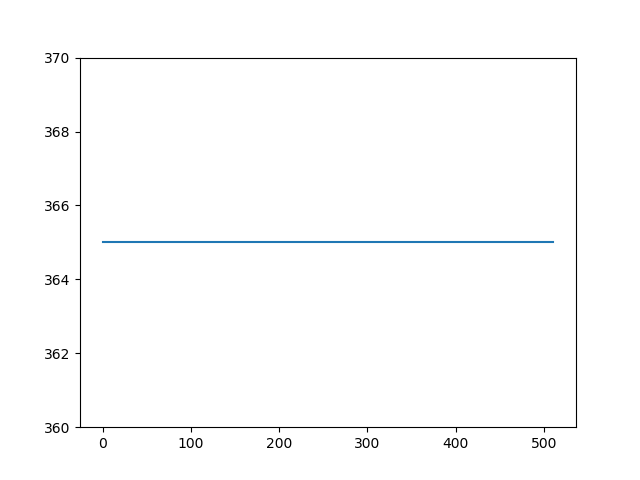

In [111]:
%matplotlib notebook
grp_delay, lowpassed_signal = lowpass_filter(audio, samplerate, 900, 1000, method='fir', 
                                  fir_method='remez', gpass=1, gstop=50, 
                                  plot_filter=False, normalize=True)
plt.plot(grp_delay)
plt.ylim([360, 370])
plt.show()
Audio(lowpassed_signal, rate=samplerate)

<IPython.core.display.Javascript object>


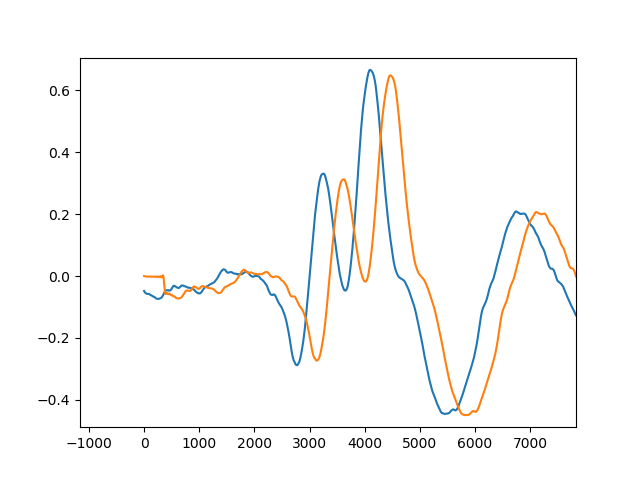

In [112]:
%matplotlib notebook
plt.plot(audio)
plt.plot(lowpassed_signal)
plt.show()

In [113]:
985 - 620

365

# Downsampling

Ventana: kaiser
Largo resp. al impulso: 4395


<IPython.core.display.Javascript object>


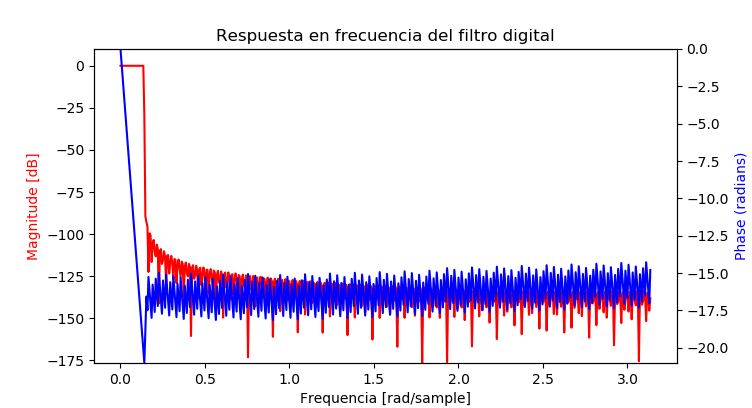

2004


In [16]:
# Disminuyendo la cantidad de muestras
freq_pass = 950
freq_stop = 1000

# Downsampleando
%matplotlib notebook
new_rate, dwns_signal = downsampling_signal(audio, samplerate, freq_pass, freq_stop, 
                                            method='lowpass', lp_method='fir', 
                                            fir_method='kaiser', gpass=1, gstop=80, 
                                            plot_filter=True, normalize=True)
print(new_rate)

# Grabando la señal
wavio.write(f"{filename}_down_{new_rate}.wav", dwns_signal, new_rate, sampwidth=3)

# Descomposición en wavelets con N niveles

<IPython.core.display.Javascript object>


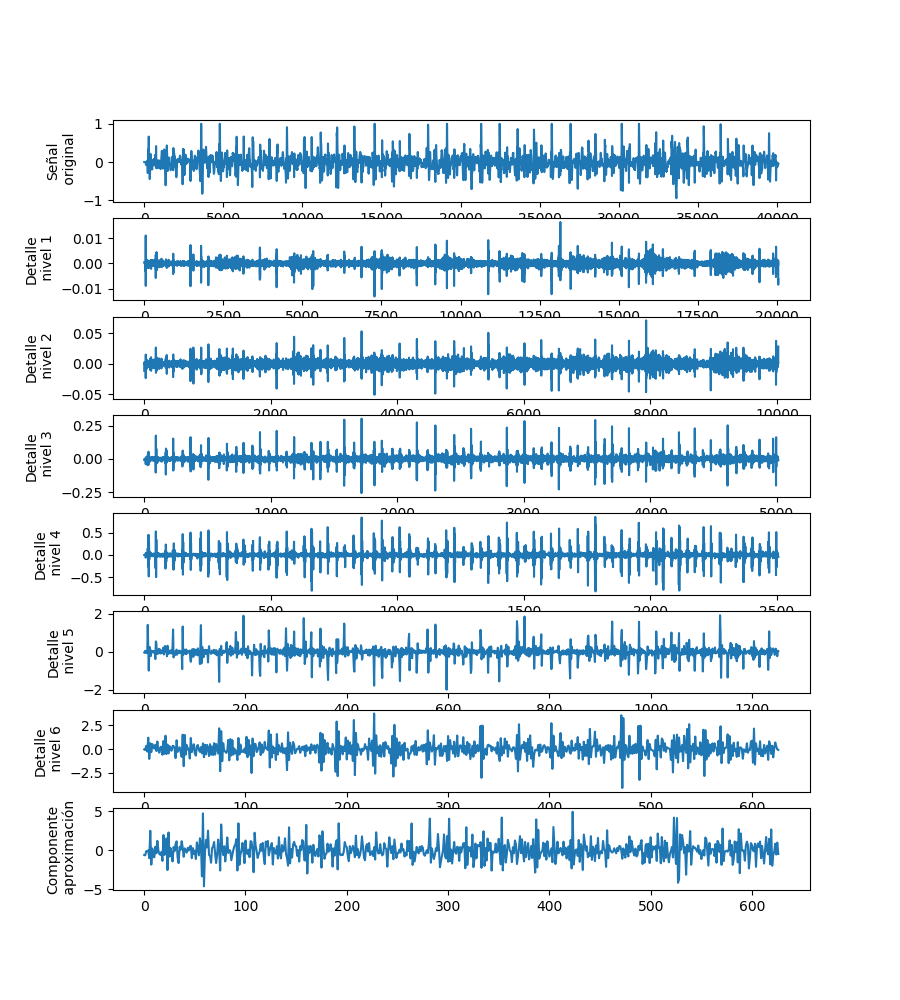

In [34]:
# Modificación de la cantidad de niveles
N = 6

# Probando DWT
dwt_values = dwt_decomposition(dwns_signal, wavelet='db4', mode='periodization',
                               levels=N, return_concatenated=False)

# Cantidad de señales obtenidas
n_plots = len(dwt_values)

# Graficando la señal original
%matplotlib notebook
plt.figure(figsize=(9,10))
plt.subplot(n_plots + 1, 1, 1)
plt.plot(dwns_signal)
plt.ylabel('Señal\n original')

# Graficando las demás señales
for i in range(n_plots):
    plt.subplot(n_plots + 1, 1, i + 2)
    plt.plot(dwt_values[i])
    
    if i == n_plots - 1:
        plt.ylabel('Componente\n aproximación')
    else:
        plt.ylabel(f'Detalle\n nivel {i+1}')

plt.show()

# Prueba de recomposición por thresholding

<IPython.core.display.Javascript object>


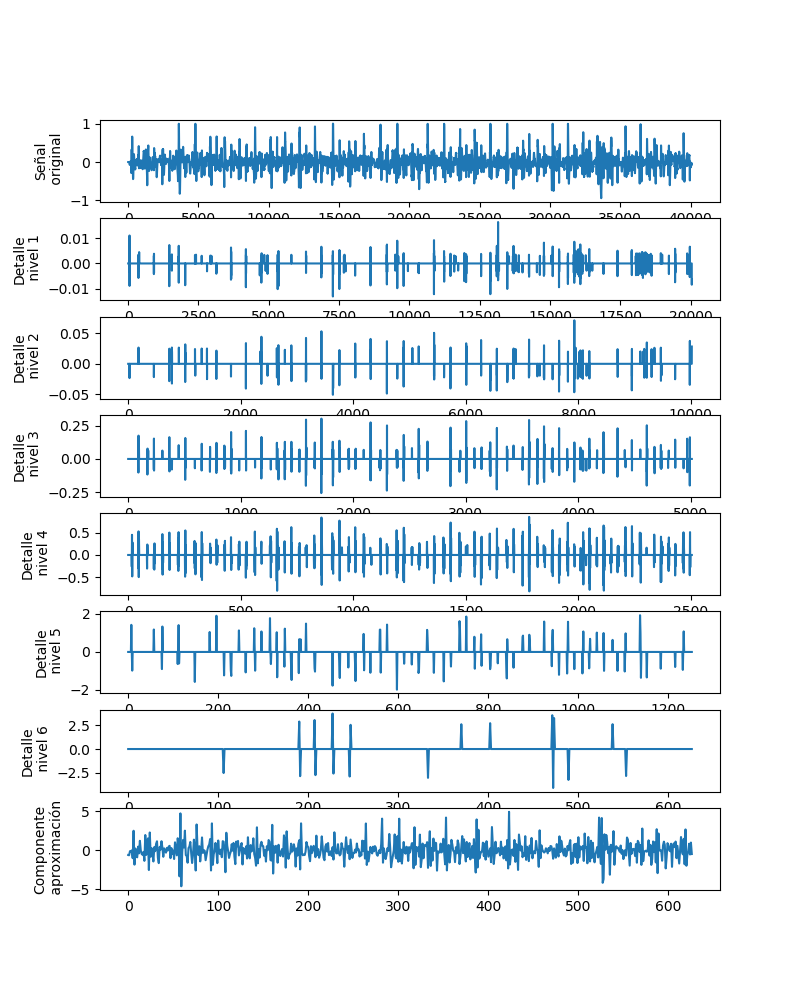

In [103]:
# Graficando la señal original
%matplotlib notebook
plt.figure(figsize=(8,10))
plt.subplot(n_plots + 1, 1, 1)
plt.plot(dwns_signal)
plt.ylabel('Señal\n original')

# Probando thresholding
n_signals = n_plots - 1 # Threshold a todos los coefs de detalle (no aproximación)
dwt_to_reconstruct = []

# Graficando las demás señales
for i in range(n_signals):
    # Aplicando thresholding
    to_plot = wavelet_thresholding(dwt_values[i], delta=None, 
                                   threshold_criteria='hard',
                                   threshold_delta='universal', 
                                   min_percentage=None, print_delta=False)
    
    plt.subplot(n_plots + 1, 1, i + 2)
    plt.plot(to_plot)
    plt.ylabel(f'Detalle\n nivel {i+1}')
        
    dwt_to_reconstruct.append(to_plot)

# Agregando y graficando el coeficiente de aproximación
dwt_to_reconstruct.append(dwt_values[-1])

plt.subplot(n_plots + 1, 1, n_plots + 1)
plt.plot(dwt_values[-1])
plt.ylabel('Componente\n aproximación')
plt.show()

<IPython.core.display.Javascript object>


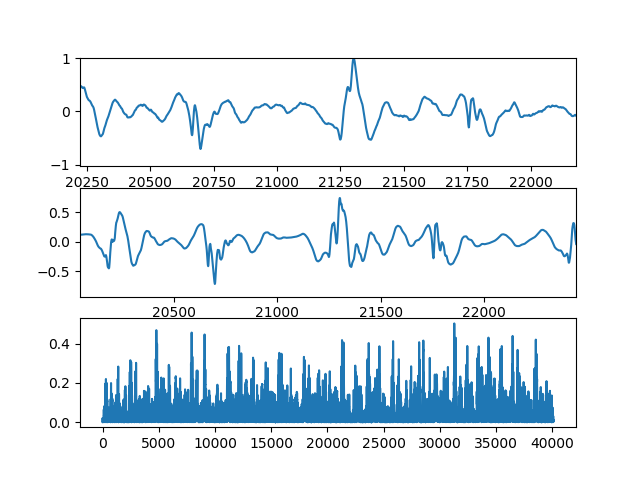

In [41]:
# Probando IDWT
recomposed_signal = dwt_recomposition(dwt_to_reconstruct, wavelet='db4', 
                                      mode='periodization', levels='all',
                                      is_concatenated=False)

%matplotlib notebook
plt.subplot(3,1,1)
plt.plot(dwns_signal)

plt.subplot(3,1,2)
plt.plot(recomposed_signal)

plt.subplot(3,1,3)
plt.plot(abs(recomposed_signal[:len(dwns_signal)] - dwns_signal))

plt.show()

# Prueba de recomposición eliminando patrones no similares al corazón

<IPython.core.display.Javascript object>


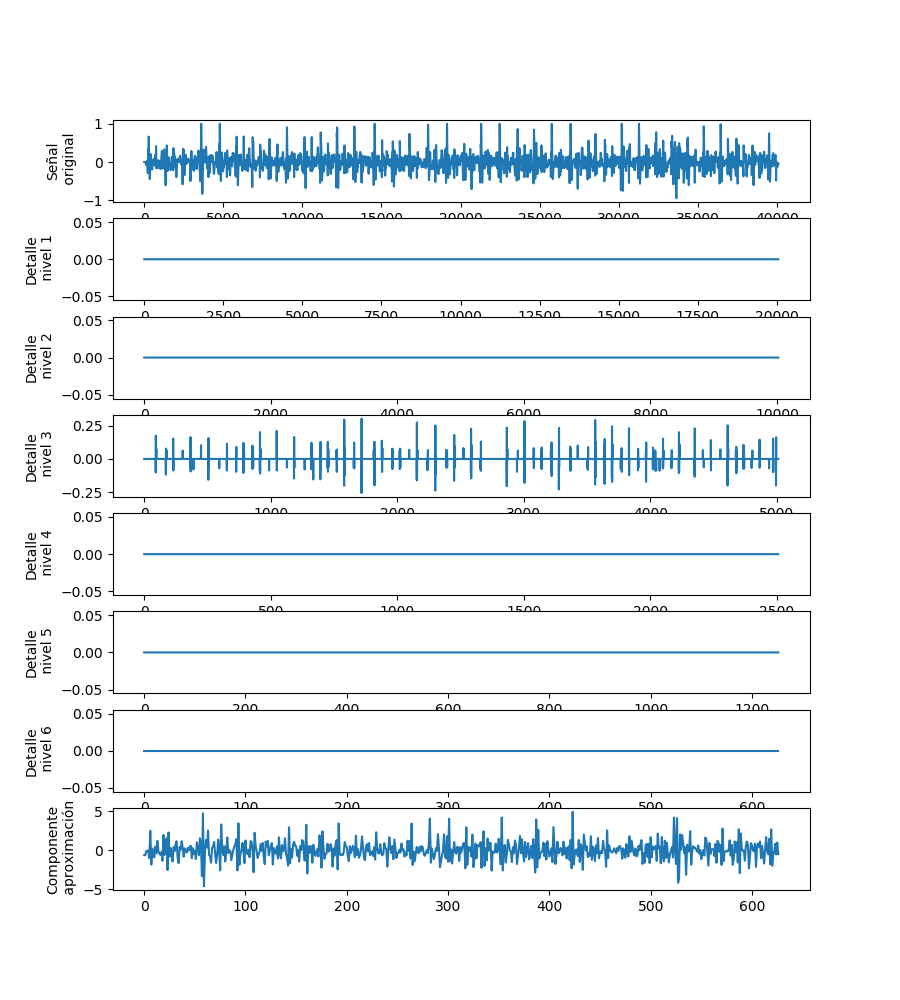

In [71]:
# Definición de la lista de los niveles a recuperar
to_sust = [3]

# Graficando la señal original
%matplotlib notebook
plt.figure(figsize=(9,10))
plt.subplot(n_plots + 1, 1, 1)
plt.plot(dwns_signal)
plt.ylabel('Señal\n original')

# Probando thresholding
n_signals = n_plots - 1 # Threshold a todos los coefs de detalle (no aproximación)
dwt_to_reconstruct = []

# Graficando las demás señales
for i in range(n_signals):
    if i + 1 in (to_sust):
        # Aplicando thresholding
        to_plot = wavelet_thresholding(dwt_values[i], delta=None, 
                                       threshold_criteria='hard',
                                       threshold_delta='universal', 
                                       min_percentage=None, print_delta=False)
    else:
        to_plot = np.array([0] * len(dwt_values[i]))
    
    plt.subplot(n_plots + 1, 1, i + 2)
    plt.plot(to_plot)
    plt.ylabel(f'Detalle\n nivel {i+1}')
        
    dwt_to_reconstruct.append(to_plot)

# Agregando y graficando el coeficiente de aproximación
dwt_to_reconstruct.append(dwt_values[-1])

plt.subplot(n_plots + 1, 1, n_plots + 1)
plt.plot(dwt_values[-1])
plt.ylabel('Componente\n aproximación')
plt.show()

<IPython.core.display.Javascript object>


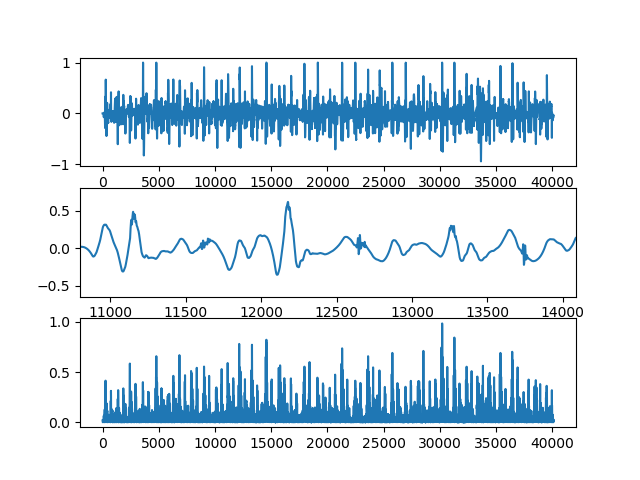

In [72]:
# Probando IDWT
recomposed_signal = dwt_recomposition(dwt_to_reconstruct, wavelet='db4', 
                                      mode='periodization', levels='all',
                                      is_concatenated=False)

%matplotlib notebook
plt.subplot(3,1,1)
plt.plot(dwns_signal)

plt.subplot(3,1,2)
plt.plot(recomposed_signal)

plt.subplot(3,1,3)
plt.plot(abs(recomposed_signal[:len(dwns_signal)] - dwns_signal))

plt.show()

# Prueba de recuperación de niveles de detalle

<IPython.core.display.Javascript object>


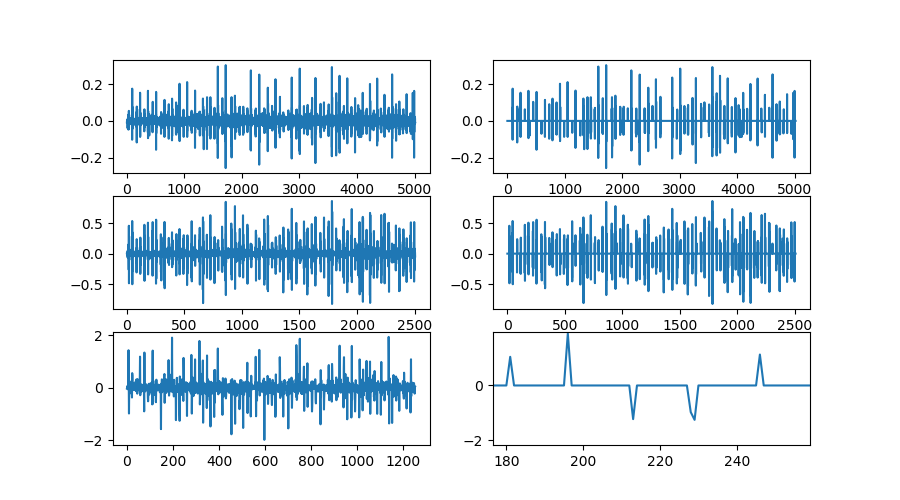

In [78]:
# Definición de la lista de los niveles a recuperar
to_sust = [3,4,5]
# Definición de la lista de wavelets a usar
wavelets_to_use = []

%matplotlib notebook
plt.figure(figsize=(9,5))

for i in range(len(to_sust)):
    # Obtención de la señal a procesar
    interest_signal = dwt_values[to_sust[i] - 1]
    
    # Aplicando thresholding
    thresh_signal = wavelet_thresholding(interest_signal, delta=None, 
                                         threshold_criteria='hard',
                                         threshold_delta='universal', 
                                         min_percentage=None, print_delta=False)
    # Agregando a la lista
    wavelets_to_use.append(thresh_signal)
    
    # Graficando
    plt.subplot(len(to_sust),2, 2*i+1)
    plt.plot(interest_signal)
    
    plt.subplot(len(to_sust),2, 2*i+2)
    plt.plot(thresh_signal)
    
plt.show()

<IPython.core.display.Javascript object>


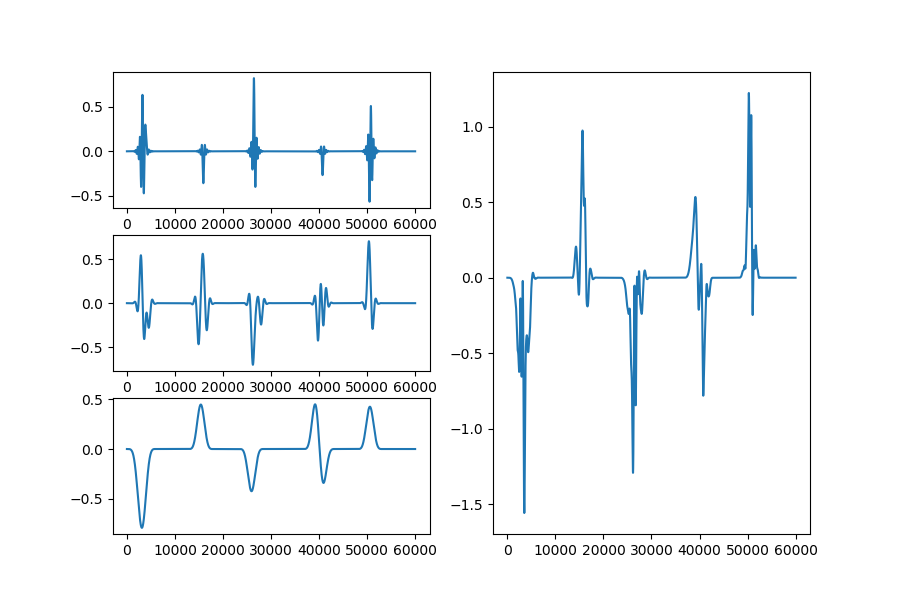

In [87]:
# Aplicando upsampling a los wavelets
%matplotlib notebook
gridsize = (3, 2)
fig = plt.figure(figsize=(9, 6))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))
ax3 = plt.subplot2grid(gridsize, (2, 0))
ax4 = plt.subplot2grid(gridsize, (0, 1), colspan=1, rowspan=3)

upsampled_wavelets = []
list_ax = [ax1, ax2, ax3]

for i in range(len(wavelets_to_use)):
    # Aplicando un upsampling
    resampled_signal = upsampling_signal(wavelets_to_use[i], new_rate / (2 ** (to_sust[i])), samplerate,
                                         N_desired=None, method='lowpass',
                                         trans_width=50, lp_method='fir', 
                                         fir_method='kaiser', gpass=1, gstop=80, 
                                         plot_filter=False, plot_signals=False,
                                         normalize=True)
    
    # Guardando
    upsampled_wavelets.append(resampled_signal)
    
    # Graficando
    list_ax[i].plot(resampled_signal[160000:220000])
    
# Suma de wavelets
wavelet_final = sum(upsampled_wavelets)
ax4.plot(wavelet_final[160000:220000])
plt.show()

<IPython.core.display.Javascript object>


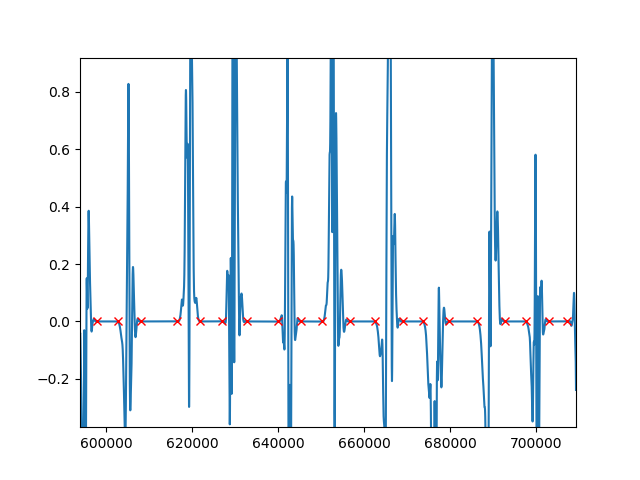

In [100]:
%matplotlib notebook
onsets = find_potential_onset_offset(wavelet_final, 'all')
plt.plot(wavelet_final)
plt.plot(onsets, [0] * len(onsets), 'rx')
plt.show()

<IPython.core.display.Javascript object>


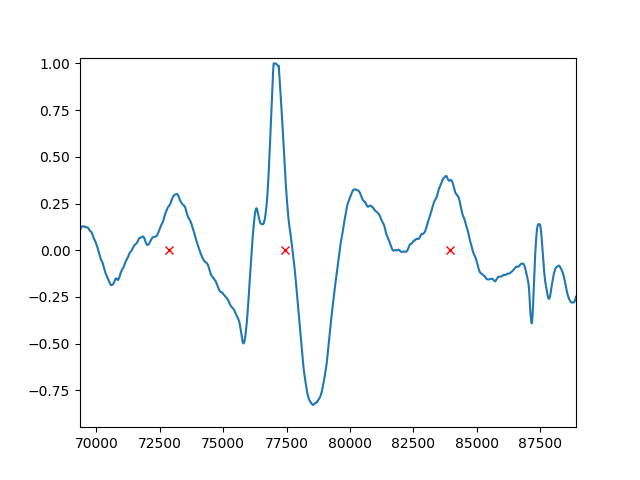

In [101]:
%matplotlib notebook
plt.plot(audio)
plt.plot(onsets, [0] * len(onsets), 'rx')
plt.show()

# TO DO: SINCRONIZAR POR EL DESFASE DEL FILTRO